In [29]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from transformers import BertTokenizer
import torch

# Load dataset
df = pd.read_csv('data/twitter.csv')

# Preprocess and encode labels
label_encoder = LabelEncoder()
df['encoded_feelings'] = label_encoder.fit_transform(df['Feeling'])

# Reset the index of the DataFrame after any filtering or manipulation
df = df.reset_index(drop=True)

# Split dataset
train_texts, val_texts, train_labels, val_labels = train_test_split(df['Tweets'], df['encoded_feelings'], test_size=0.2)

# Initialize tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenization
train_encodings = tokenizer(list(train_texts), truncation=True, padding=True, max_length=128)
val_encodings = tokenizer(list(val_texts), truncation=True, padding=True, max_length=128)

In [30]:
from torch.utils.data import Dataset

class TweetDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels.iloc[idx])  # Use .iloc for labels
        return item

    def __len__(self):
        return len(self.labels)

    
# Assuming your tokenized data is in train_encodings and val_encodings
# and your labels are in train_labels and val_labels
train_dataset = TweetDataset(train_encodings, train_labels)
val_dataset = TweetDataset(val_encodings, val_labels)

In [24]:
# Check the first few entries in the label Series
print(df['encoded_feelings'].head())

# Check if index 0 exists
print(df['encoded_feelings'][0])

0    3
1    3
2    3
3    3
4    3
Name: encoded_feelings, dtype: int64
3


In [27]:
# Verify the first few entries in train_texts
print(train_texts.head())

# Try accessing the first few entries
for i in range(5):
    print(train_texts.iloc[i])

6669     #4: @Jen Robinson ed "RT @paulajaynebyrne: Bo...
1933     #46: @インドトラブル解決屋 まっちゃん ed "@tokyo2africa ナイロビ...
6737     #72: @ShubzyShubzyShubzy ed "RT @IslamicTongu...
6419     #28: @Elise ed "RT @grimelliottini: Clearly m...
7457     #29: @Ирина Севостьянова ed "What a pleasant ...
Name: Tweets, dtype: object
 #4: @Jen Robinson ed "RT @paulajaynebyrne: Bored of fake modesty. Paul Johnson described this as ‘the best book on Jane Austen I have ever read!’ RT and I’ll pic…"
 #46: @インドトラブル解決屋 まっちゃん ed "@tokyo2africa ナイロビ国内、、ってことですよね？？"
 #72: @ShubzyShubzyShubzy ed "RT @IslamicTongue: Sisters, hijab is not a fashion statement, it is an act of worship first and foremost. Keep your modesty intact. May All…"
 #28: @Elise ed "RT @grimelliottini: Clearly morals of humanity are all an act. Pathetic... we think we are the best...@ChurchofSatan has it right"Satan r…"
 #29: @Ирина Севостьянова ed "What a pleasant surprise! In 7 minutes i will be performing completely naked in this chat! Сome 

In [2]:
display(df.head())

,Sl no,Tweets,Search key,Feeling,encoded_emotions
0,1,"#1: @fe ed ""RT @MirayaDizon1: Time is ticking...",happy moments,happy,3
1,2,"#2: @蓮花 &はすか ed ""RT @ninjaryugo: ＃コナモンの日 だそうで...",happy moments,happy,3
2,3,"#3: @Ris ♡ ed ""Happy birthday to one smokin h...",happy moments,happy,3
3,4,"#4: @월월 [씍쯴사랑로봇] jwinnie is the best, cheer u...",happy moments,happy,3
4,5,"#5: @Madhurima wth u vc♥ ed ""Good morning dea...",happy moments,happy,3


/home/malrogi101/miniconda3/envs/mathML/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


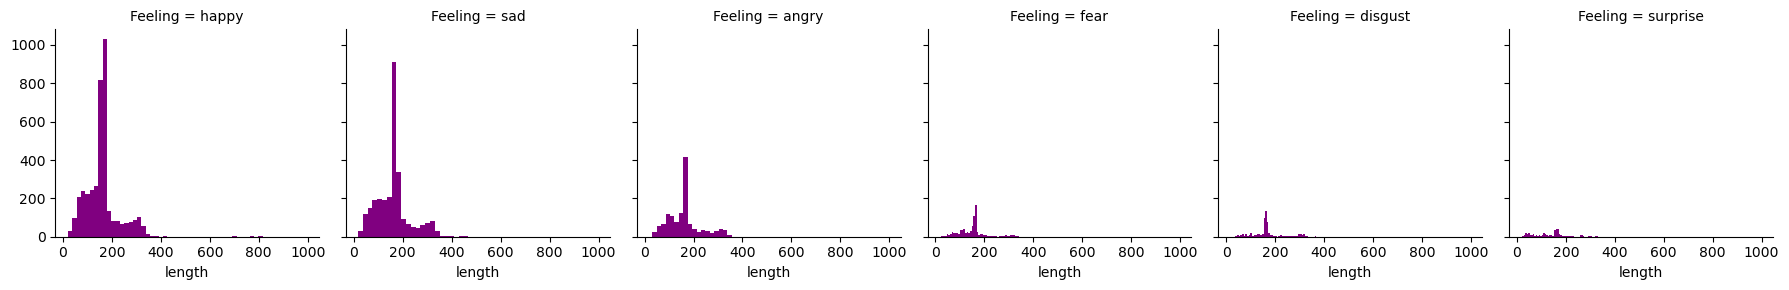

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
df.describe(include='all')
df['length'] = df['Tweets'].apply(len)
df.head()
graph = sns.FacetGrid(data=df,col='Feeling')
graph.map(plt.hist,'length',bins=50,color='Purple')

In [4]:
# Calculate label frequencies
label_frequencies = df['Feeling'].value_counts()

# Print the frequencies
print(label_frequencies)

Feeling
happy       3928
sad         2849
angry       1341
fear         863
disgust      637
surprise     399
Name: count, dtype: int64


In [31]:
print(train_labels[1])
print(len(val_dataset))


3
2004


In [32]:
# Load pre-trained BERT model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=6)

# Calculate class weights
class_weights = compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels)
class_weights = torch.tensor(class_weights, dtype=torch.float)

# Pass class weights to loss function
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    weight_decay=0.01,
    logging_dir='./logs',
    evaluation_strategy='steps',  # Set evaluation to occur at regular intervals
    eval_steps=50,               # Evaluate every 50 steps (adjust as needed)
    save_strategy='steps',       # Save at regular intervals
    save_steps=50,               # Save every 50 steps (should match eval_steps)
    load_best_model_at_end=True  # Load the best model at the end of training
)


# Define Trainer with class weights
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=None  # You can define a custom compute_metrics function if needed
)

# Train the model
trainer.train()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss
50,No log,1.368226
100,No log,0.886317
150,No log,0.539462
200,No log,0.397964
250,No log,0.362704
300,No log,0.351977
350,No log,0.320445
400,No log,0.310103
450,No log,0.342750
500,0.611300,0.327543


TrainOutput(global_step=1503, training_loss=0.31806276801103606, metrics={'train_runtime': 13433.5231, 'train_samples_per_second': 1.789, 'train_steps_per_second': 0.112, 'total_flos': 1581288453914112.0, 'train_loss': 0.31806276801103606, 'epoch': 3.0})

In [34]:
from torch.utils.data import DataLoader

# Assuming val_dataset is your validation dataset
val_loader = DataLoader(val_dataset, batch_size=512, shuffle=False)

# Switch model to evaluation mode
model.eval()

predictions = []
actuals = []

# No gradient is needed for validation
with torch.no_grad():
    for batch in val_loader:
        inputs = batch['input_ids']
        labels = batch['labels']
        outputs = model(inputs)

        # Extract logits
        logits = outputs.logits  # Extract logits from SequenceClassifierOutput
        
        # Convert logits to probabilities and then to predicted class
        probs = torch.nn.functional.softmax(logits, dim=1)
        predicted_classes = torch.argmax(probs, dim=1)
        
        predictions.extend(predicted_classes.cpu().numpy())
        actuals.extend(labels.cpu().numpy())

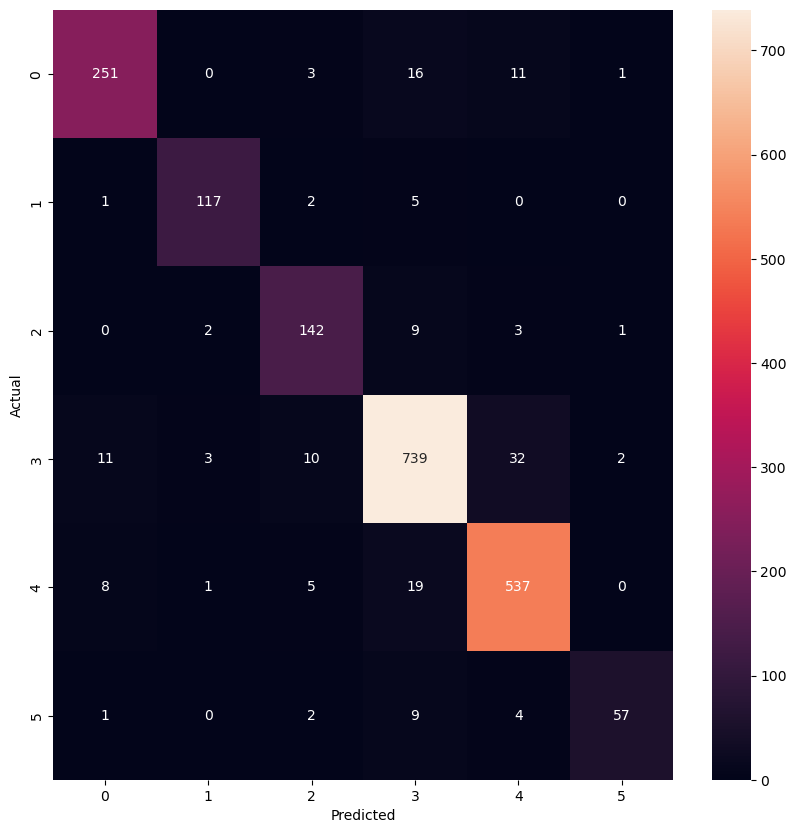

In [35]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Generate the confusion matrix
cm = confusion_matrix(actuals, predictions)

# Plotting the confusion matrix
plt.figure(figsize=(10,10))
sns.heatmap(cm, annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [36]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

# Calculate metrics
accuracy = accuracy_score(actuals, predictions)
recall = recall_score(actuals, predictions, average='weighted')  # Use 'binary' for binary classification
precision = precision_score(actuals, predictions, average='weighted')  # Use 'binary' for binary classification
f1 = f1_score(actuals, predictions, average='weighted')  # Use 'binary' for binary classification

# Print the metrics
print(f"Accuracy: {accuracy}")
print(f"Recall: {recall}")
print(f"Precision: {precision}")
print(f"F1 Score: {f1}")

Accuracy: 0.9196606786427146
Recall: 0.9196606786427146
Precision: 0.9200252296562192
F1 Score: 0.9194570385971799
